In [178]:
%matplotlib inline
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
import itertools
import random
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale, normalize

In [179]:
def load_mnist(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')    

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:           
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num = struct.unpack(">II", fimg.read(8))        
        rows, cols = struct.unpack(">II", fimg.read(8))        
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])
    return (lbl, img)

    # Create an iterator which returns each image in turn
    #for i in range(len(lbl)):
    #    yield get_img(i)

In [180]:
def transform_image(img):
    return np.reshape(img, (784, 1))

def transform_label(j, n=10):
    e = np.zeros((n, 1))
    e[j] = 1.0
    return e

In [181]:
%%time

train_labels, train_images = load_mnist(dataset = "training", path = "data/")
test_labels, test_images = load_mnist(dataset = "testing", path = "data/")

train_images = np.array(list(map(transform_image, train_images)))
test_images  = np.array(list(map(transform_image, test_images)))
train_labels = np.array(list(map(transform_label, train_labels)))
test_labels  = np.array(list(map(transform_label, test_labels)))
#print (train_images[2])

CPU times: user 336 ms, sys: 32 ms, total: 368 ms
Wall time: 369 ms


In [182]:
def binarize_images(imgs):
    return (imgs > 120).astype(int)

def standartize_images(imgs):
    return scale(imgs, axis=1)

train_images = binarize_images(train_images)
test_images = binarize_images(test_images)
#print (train_images[120])

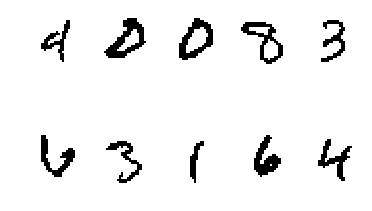

In [183]:

np.random.seed(42)

train_indices = np.random.randint(0, len(train_images), 10)

for ix, image in enumerate(train_images[train_indices]):
    plt.subplot(2, 5, ix + 1)
    plt.axis("off")
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

In [184]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def sigmoid_der(x):
    s = sigmoid(x)    
    return s * (1 - s)
    #print (np.diag(s*(1-s)).shape)
    #return np.diag(s * (1 - s))


In [185]:
class NNClassifier(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]        

    def feedforward(self, X):
        for b, w in zip(self.biases, self.weights):
            X = sigmoid(np.dot(w, X) + b)
        return X
    
    def predict(self, X):
        return np.argmax(self.feedforward(X))

    def SGD(self, train_data, epochs, mini_batch_size, eta):
        n = len(train_data)
        for j in range(epochs):
            random.shuffle(train_data)
            mini_batches = [
                train_data[k : k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            accuracy = self.accuracy(train_data) / n
            print("epoch=%d: accuracy=%.3f" % (j, accuracy))

    def update_mini_batch(self, mini_batch, eta):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_grad_b, delta_grad_w = self.backprop(x, y)
            grad_b = [nb + dnb for nb, dnb in zip(grad_b, delta_grad_b)]
            grad_w = [nw + dnw for nw, dnw in zip(grad_w, delta_grad_w)]
        self.weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, grad_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, grad_b)]

    def backprop(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        # Forward propagation of weights
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # Backward propagation of weights        
        delta = activations[-1] - y
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            der_sigma = sigmoid_der(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * der_sigma
            grad_b[-l] = der_sigma
            grad_w[-l] = np.dot(der_sigma, activations[-l-1].transpose())
        return (grad_b, grad_w)

    def accuracy(self, data, convert=False):
        results = [(self.predict(x), np.argmax(y))
                   for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

In [190]:
%%time
b
train_data = list(zip(train_images, train_labels))

clf = NNClassifier([784, 300, 10])
clf.SGD(train_data, 3, 64, 0.1)

epoch=0: accuracy=0.112
epoch=1: accuracy=0.112


KeyboardInterrupt: 

In [ ]:
%%time

# Compute predictions
y_true = np.argmax(test_labels, axis=1).T[0]
y_pred = np.array([np.argmax(clf.feedforward(x)) for x in test_images])

In [187]:
score = accuracy_score(y_true, y_pred)
print("Error rate: %.1f%%" % (100 * (1 - score)))

ValueError: shapes (784,1) and (784,256) not aligned: 1 (dim 1) != 784 (dim 0)

In [189]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(16, 8))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.colorbar()
classes = range(10)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid("off")

# Plot digits of confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "%.2f" % cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


plt.show()

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [ ]:
wrong_ones = []
for d in range(10):
    wrong_ones.append([])

for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true != pred:
        img = test_images[i]
        wrong_ones[true].append((img, pred, i))

In [ ]:
topN = 5

plt.figure(figsize=(16, 16))
for d in range(10):
    for k, (img, pred, i) in enumerate(wrong_ones[d][:topN]):
        plt.subplot(10, topN, topN * d + k + 1)
        plt.axis("off")
        plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
        plt.title("I=%d Predicted: %d" % (i, pred))
plt.show()

In [ ]:
score = accuracy_score(y_true, y_pred)
print("Error rate: %.1f%%" % (100 * (1 - score)))

In [ ]:
from PIL import Image
FILENAME = "9.png"
pil_image = Image.open("data/manual/" + FILENAME).resize((28, 28))
img = (255 - np.asarray(pil_image.convert("L")))

In [ ]:
img = transform_image(img)
img = standartize_images([img])[0]

In [ ]:
plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")

In [ ]:
y_additional_pred = predict(net, img)
print("Predicted value: %d" % y_additional_pred)